In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "hochgerner_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 24185 × 27933
    obs: 'labels', 'age'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,labels,age
10X79_1_AAACTAGCTAGCCC-,neuroblast,P120
10X79_1_AAACTAGGATGTAT-,oligodendrocyte precursor cell,P120
10X79_1_AAACTCACGGCGTT-,granule cell,P120
10X79_1_AAACTGTCGGCTCA-,oligodendrocyte,P120
10X79_1_AAACTGTGATAAGT-,oligodendrocyte precursor cell,P120


In [4]:
colors = {
    # Excitatory neurons
    "immature pyramidal neuron": "#DE6093",
    "pyramidal neuron": "#D5221C",
    "immature granule cell": "#FEE00D",
    "juevnile granule cell": "#FAB508",
    "granule cell": "#FFA02C",
    # Inhibitory neurons
    "immature GABAergic neuron": "#74C9FF",
    "GABAergic neuron": "#68A8E6",
    "Cajal-Retzius cell": "#1C6865",
    # Neural progenitors
    "neuroblast": "#FEA388",
    "neuronal intermediate progenitor cells": "#FF7390",
    # Glia
    "ependymal cell": "#967D78",
    "oligodendrocyte precursor cell": "#9F9F9F",
    "newly formed oligodendrocyte": "#787878",
    "oligodendrocyte": "#505050",
    "immature astrocyte": "#9B7E7B",
    "juvenile astrocyte": "#846F57",
    "astrocyte": "#655C4A",
    "glial cell": "#7C9672",
    "radial glial cell": "#684644",
    
    "endothelial cell": "#5300FF",
    "vascular and leptomeningeal cell": "#8E97E4",
    "perivascular macrophage": "#8655F1",
}

## Preprocessing

In [5]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 24185 × 17670
    obs: 'labels', 'age'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.30
CPU times: user 1.99 s, sys: 2.07 s, total: 4.06 s
Wall time: 3.88 s


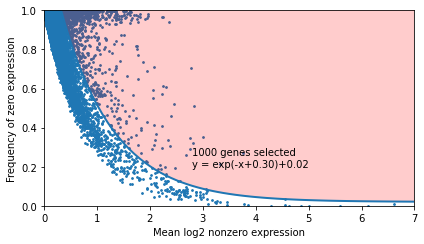

In [6]:
%time gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [7]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

In [8]:
adata.obsm["X_pca"] = x_pca = utils.pca(adata.X[:, gene_mask])

### Multiscale embedding

In [10]:
init = openTSNE.initialization.rescale(adata.obsm["X_pca"][:, :2])
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding = openTSNE.TSNE(
    initialization=init,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"], affinities=affinities)

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 21.92 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 22.54 seconds
--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.1094774e-04, -5.7259651e-05],
       [ 2.2777975e-04,  1.7932995e-04],
       [ 2.7671264e-04, -7.6406694e-05],
       ...,
       [ 3.5341948e-04, -1.1852314e-04],
       [ 4.4436660e-04, -1.3557584e-04],
       [ 3.5082892e-04, -4.1014413e-05]], dtype=float32),
     n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2015.42 for 250 iterations...
Iteration   50, KL divergence 3.4488, 50 iterations in 6.7528 sec
Iteration  100, KL divergence 3.0774, 50 iterations in 7.0089 sec
Iteration  150, KL divergence 2.9900, 50 iterations in 7.0617 sec
Iteration  200, KL

In [11]:
adata.obsm["X_tsne"] = embedding.view(np.ndarray)

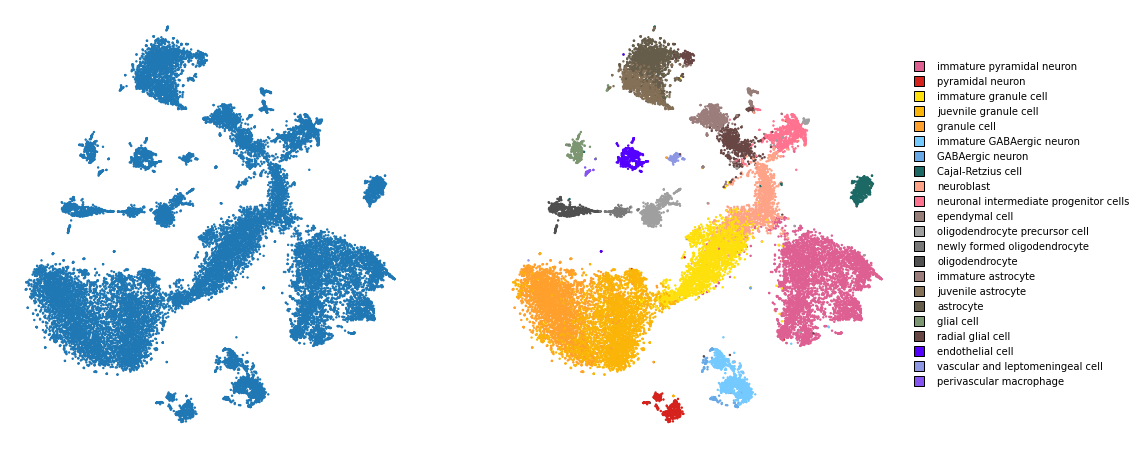

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names),
           s=2, alpha=1, draw_legend=False, ax=ax[0])
utils.plot(adata.obsm["X_tsne"], adata.obs["labels"].values,
           colors=colors, label_order=list(colors.keys()),
           s=2, alpha=1, draw_legend=True, ax=ax[1])

## Reload hochgerner

In [13]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "hochgerner_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 24185 × 27933
    obs: 'labels', 'age'
    uns: 'name', 'organism', 'tissue', 'year'

In [14]:
adata.obsm["X_pca"] = x_pca
adata.obsm["X_tsne"] = embedding.view(np.ndarray)

## Load harris

In [15]:
new = anndata.read_h5ad(path.join("..", "data", "h5ad", "harris_2018.h5ad"))
new

AnnData object with n_obs × n_vars = 6971 × 27933
    uns: 'name', 'organism', 'tissue', 'year'

## Align data sets

In [16]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes(new, min_counts=10)

In [17]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610012G03Rik',
       '0610030E20Rik', '0610037L13Rik',
       ...
       'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3',
       'mt-Nd4', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=15492)

In [18]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [19]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 0.27


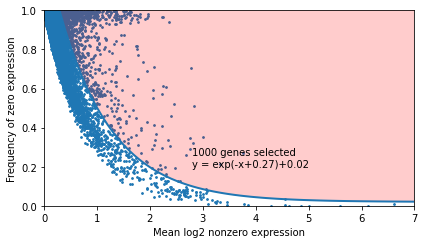

In [20]:
gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [21]:
adata_1000 = adata[:, gene_mask]
new_1000 = new[:, gene_mask]

## Find embeddings for new data

In [22]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    adata_1000.X.toarray(),
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 9.72 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.55 seconds
CPU times: user 44.5 s, sys: 924 ms, total: 45.4 s
Wall time: 10.4 s


In [23]:
embedding = openTSNE.TSNEEmbedding(
    adata.obsm["X_tsne"],
    affinities,
    n_jobs=8,
    verbose=True,
)

In [65]:
%time new_embedding0 = embedding.prepare_partial(new_1000.X.toarray(), perplexity=30)

===> Finding 90 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 4.21 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.13 seconds
CPU times: user 13.8 s, sys: 304 ms, total: 14.1 s
Wall time: 4.39 s


In [102]:
%%time
new_embedding = new_embedding0.optimize(750, learning_rate=0.1, exaggeration=100)
new_embedding = new_embedding.optimize(750, learning_rate=1, exaggeration=1)

===> Running optimization with exaggeration=100.00, lr=0.10 for 750 iterations...
Iteration   50, KL divergence 119659.0077, 50 iterations in 0.2648 sec
Iteration  100, KL divergence 119408.5149, 50 iterations in 0.2305 sec
Iteration  150, KL divergence 119338.9695, 50 iterations in 0.2270 sec
Iteration  200, KL divergence 119313.5885, 50 iterations in 0.2274 sec
Iteration  250, KL divergence 119305.1299, 50 iterations in 0.2252 sec
Iteration  300, KL divergence 119301.3078, 50 iterations in 0.2291 sec
Iteration  350, KL divergence 119299.7897, 50 iterations in 0.2256 sec
Iteration  400, KL divergence 119296.6820, 50 iterations in 0.2255 sec
Iteration  450, KL divergence 119295.7171, 50 iterations in 0.2198 sec
Iteration  500, KL divergence 119294.6617, 50 iterations in 0.2205 sec
Iteration  550, KL divergence 119295.5243, 50 iterations in 0.2190 sec
Iteration  600, KL divergence 119295.5891, 50 iterations in 0.2222 sec
Iteration  650, KL divergence 119295.0684, 50 iterations in 0.2248

In [103]:
new.obsm["X_tsne"] = new_embedding.view(np.ndarray)

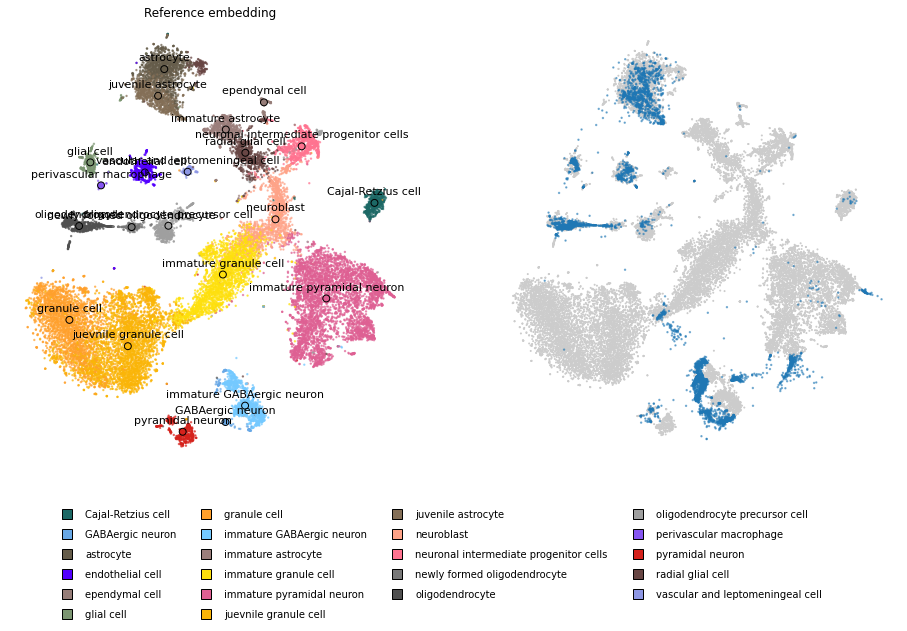

In [104]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

utils.plot(
    adata.obsm["X_tsne"], adata.obs["labels"], ax=ax[0], title="Reference embedding", s=2, colors=colors,
    draw_centers=True, draw_cluster_labels=True, fontsize=11,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax[1],
           colors=colors_bw, alpha=1, s=1, draw_legend=False)
utils.plot(new_embedding, np.ones_like(new_1000.obs.index), ax=ax[1],
           draw_legend=False, s=2, alpha=0.5, colors={1: "tab:blue"})
#ax[1].set_title("Transformed samples")

for ax_ in ax.ravel(): ax_.axis("equal")

## Examine markers

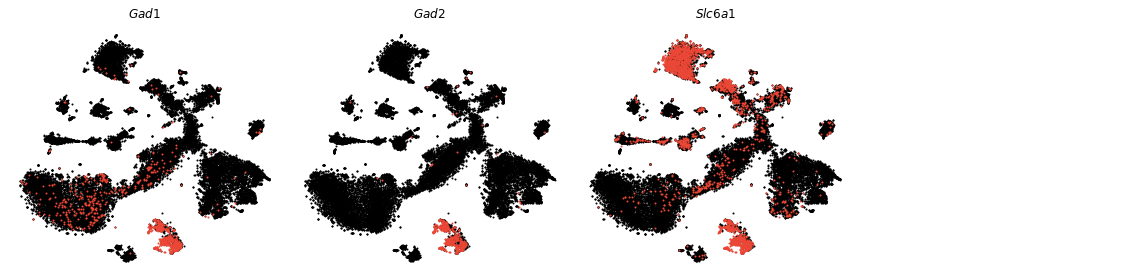

In [105]:
utils.plot_markers(["Gad1", "Gad2", "Slc6a1"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

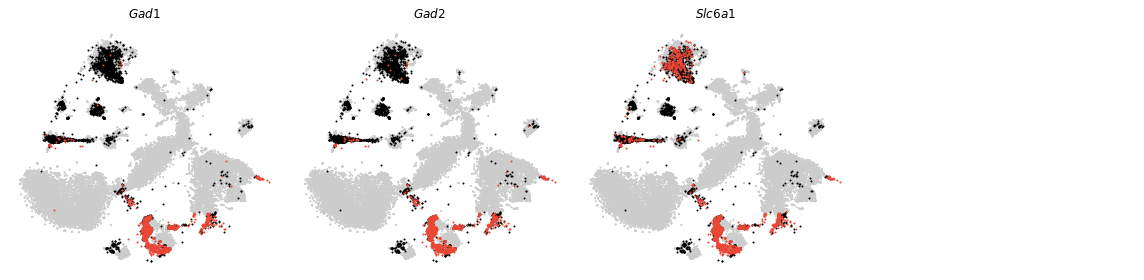

In [106]:
fig, ax = utils.plot_markers(["Gad1", "Gad2", "Slc6a1"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:3]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

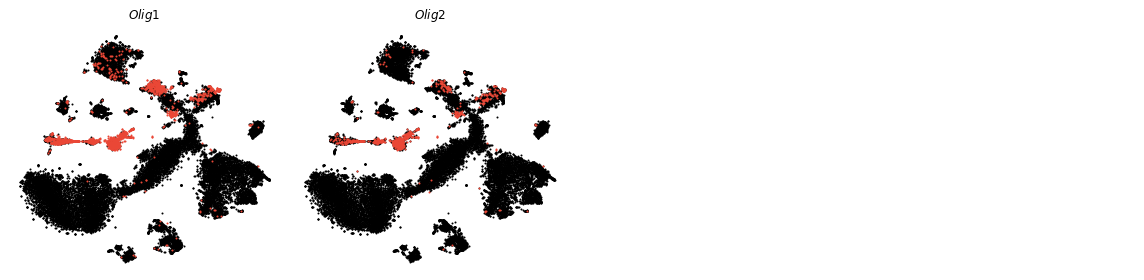

In [107]:
utils.plot_markers(["Olig1", "Olig2"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

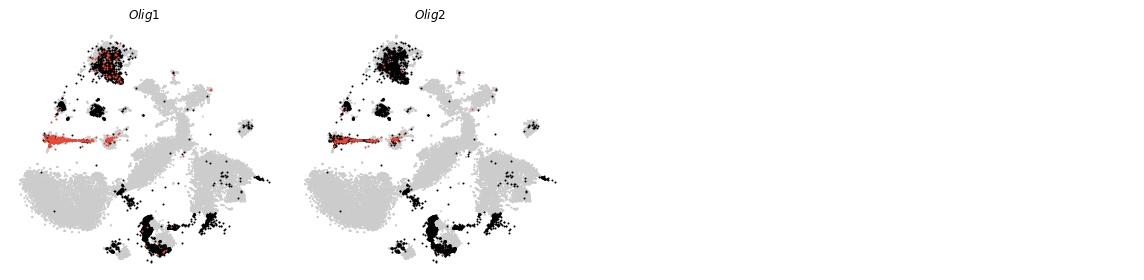

In [108]:
fig, ax = utils.plot_markers(["Olig1", "Olig2"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:2]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

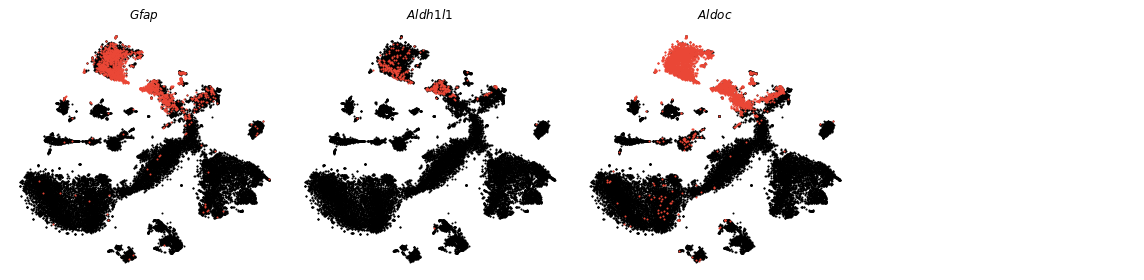

In [109]:
utils.plot_markers(["Gfap", "Aldh1l1", "Aldoc"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

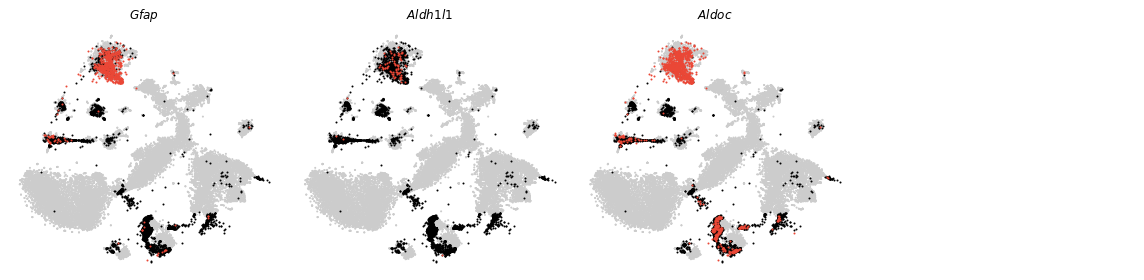

In [110]:
fig, ax = utils.plot_markers(["Gfap", "Aldh1l1", "Aldoc"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:3]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

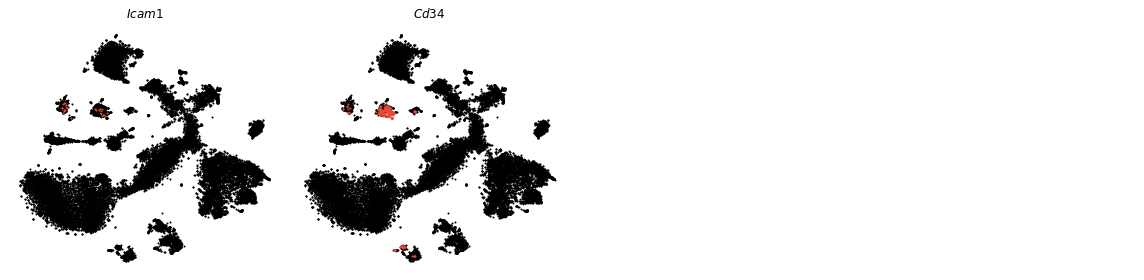

In [111]:
utils.plot_markers(["Icam1", "Cd34"], adata, adata.obsm["X_tsne"], alpha=1, threshold=1)

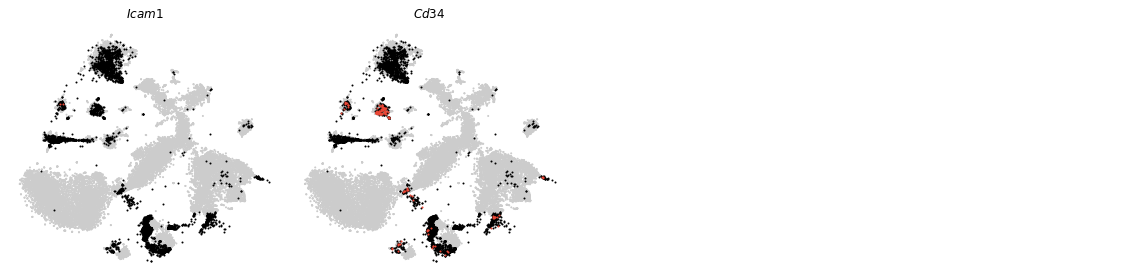

In [112]:
fig, ax = utils.plot_markers(["Icam1", "Cd34"], new, new.obsm["X_tsne"], alpha=1, threshold=1, zorder=2, return_ax=True)
for ax_ in ax.ravel()[:2]:
    colors_bw = {1: "#CCCCCC"}
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

## Final figure

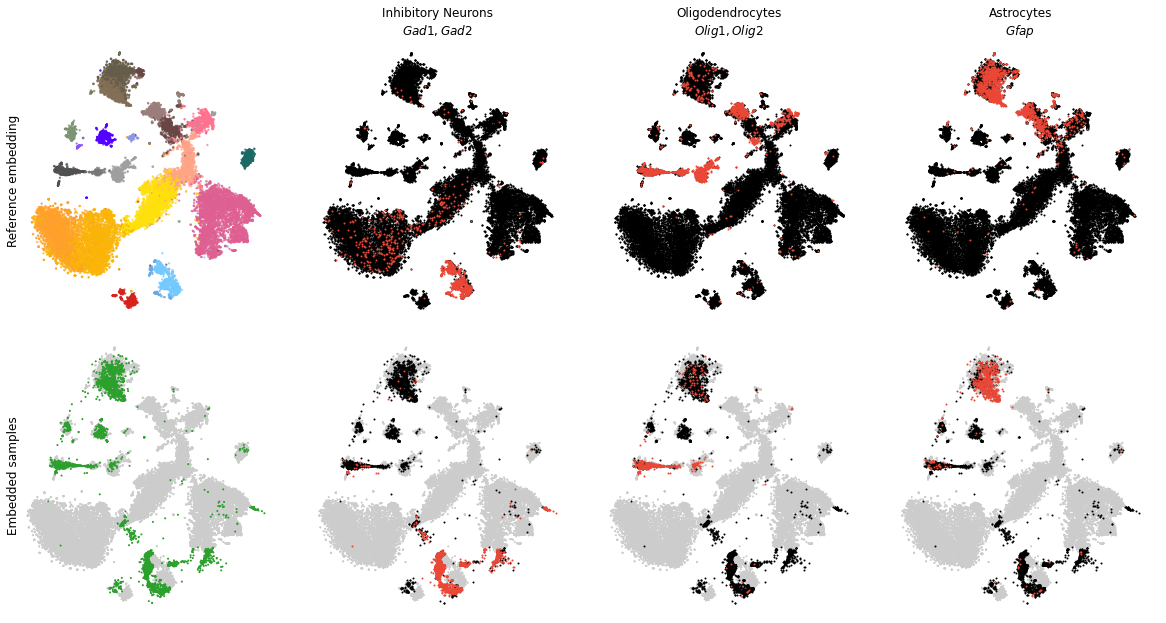

In [114]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))

ax[0, 0].text(-0, 0.5, "Reference embedding", transform=ax[0, 0].transAxes,
              rotation=90, verticalAlignment="center", size="large")
ax[1, 0].text(-0, 0.5, "Embedded samples", transform=ax[1, 0].transAxes,
              rotation=90, verticalAlignment="center", size="large")

utils.plot(
    adata.obsm["X_tsne"], adata.obs["labels"], ax=ax[0, 0], s=2, colors=colors,
    draw_centers=False, draw_cluster_labels=False, fontsize=11, draw_legend=False,
    legend_kwargs=dict(
        loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure,
        labelspacing=1, ncol=4
    )
)

colors_bw = {1: "#CCCCCC"}
utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax[1, 0],
           colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)
utils.plot(new_embedding, np.ones_like(new_1000.obs.index), ax=ax[1, 0],
           draw_legend=False, s=1, alpha=1, colors={1: "tab:green"}, zorder=2)


# Plot reference silhouette onto bottom row
for ax_ in ax[1, :].ravel():
    utils.plot(adata.obsm["X_tsne"], np.ones_like(adata.obs_names), ax=ax_,
               colors=colors_bw, alpha=1, s=1, draw_legend=False, zorder=1)

marker_params = dict(binary=True, alpha=1, threshold=1)
# Reference embeddings
utils.plot_marker(["Gad1", "Gad2"], adata, adata.obsm["X_tsne"], ax=ax[0, 1], **marker_params)
utils.plot_marker(["Olig1", "Olig2"], adata, adata.obsm["X_tsne"], ax=ax[0, 2], **marker_params)
utils.plot_marker(["Gfap"], adata, adata.obsm["X_tsne"], ax=ax[0, 3], **marker_params)
# Transformed embeddings
utils.plot_marker(["Gad1", "Gad2"], new, new.obsm["X_tsne"], ax=ax[1, 1], **marker_params)
utils.plot_marker(["Olig1", "Olig2"], new, new.obsm["X_tsne"], ax=ax[1, 2], **marker_params)
utils.plot_marker(["Gfap"], new, new.obsm["X_tsne"], ax=ax[1, 3], **marker_params)

ax[0, 1].set_title(f"Inhibitory Neurons\n{ax[0, 1].get_title()}")
ax[0, 2].set_title(f"Oligodendrocytes\n{ax[0, 2].get_title()}")
ax[0, 3].set_title(f"Astrocytes\n{ax[0, 3].get_title()}")

for ax_ in ax.ravel():
    ax_.set_xticks([]), ax_.set_yticks([])
    ax_.set_axis_off()
    ax_.axis("equal")
    
for ax_ in ax[1].ravel():
    ax_.set_title("")
    
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

#plt.savefig(path.join("..", "figures", "transform_hochgerner.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=8)
plt.savefig(path.join("..", "figures", "transform_hochgerner.pdf"), dpi=72, bbox_inches="tight", transparent=True, width=1200/72, height=1200/2/72)
#plt.savefig(path.join("..", "figures", "transform_hochgerner.tiff"), dpi=130, bbox_inches="tight", transparent=True, width=16, height=8)